# Quantum Teleportation
This notebook demonstrates quantum teleportation. We first use Qiskit's built-in simulators to test our quantum circuit, and then try it out on a real quantum computer.


In [1]:
# Do the necessary imports
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.extensions import Initialize
from qiskit.ignis.verification import marginal_counts
from qiskit.quantum_info import random_statevector

## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers

qr = QuantumRegister(3, name="q")    # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical bits
crx = ClassicalRegister(1, name="crx") # in 2 different registers
teleportation_circuit = QuantumCircuit(qr, crz, crx)

/var/folders/gh/whjbvc2n0yq7x_9c514zdjyh0000gn/T/ipykernel_15424/28557839.py:7: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.verification import marginal_counts


## Step 1 

A third party, Telamon, creates an entangled pair of qubits and gives one to Bob and one to Alice.
The pair Telamon creates is a special pair called a Bell pair. In quantum circuit language, the way to create a Bell pair between two qubits is to first transfer one of them to the X-basis ( 
|+⟩and|−⟩) using a Hadamard gate, and then to apply a CNOT gate onto the other qubit controlled by the one in the X-basis.

In [2]:
def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target
    
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
# In our case, Telamon entangles qubits q1 and q2
# Let's apply this to our circuit:
create_bell_pair(teleportation_circuit, 1, 2)
# And view the circuit so far:
teleportation_circuit.draw()

q_0: ──────────
       ┌───┐     
  q_1: ┤ H ├──■──
       └───┘┌─┴─┐
  q_2: ─────┤ X ├
            └───┘
crz: 1/══════════
                 
crx: 1/══════════

Let's say Alice owns q1 and Bob owns q2 after they part ways.



## Step 2 

Alice applies a CNOT gate to q1, controlled by|ψ⟩(the qubit she is trying to send Bob). Then Alice applies a Hadamard gate to |ψ⟩. In our quantum circuit, the qubit (|ψ⟩) Alice is trying to send is q0:

In [3]:
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)
    
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)
teleportation_circuit.draw()

░      ┌───┐
  q_0: ───────────░───■──┤ H ├
       ┌───┐      ░ ┌─┴─┐└───┘
  q_1: ┤ H ├──■───░─┤ X ├─────
       └───┘┌─┴─┐ ░ └───┘     
  q_2: ─────┤ X ├─░───────────
            └───┘ ░           
crz: 1/═══════════════════════
                              
crx: 1/═══════════════════════

## Step 3 

Next, Alice applies a measurement to both qubits that she owns, q1 and |ψ⟩, and stores this result in two classical bits. She then sends these two bits to Bob.

In [4]:
def measure_and_send(qc, a, b):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)

## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)

## STEP 3
measure_and_send(teleportation_circuit, 0 ,1)
teleportation_circuit.draw()

░      ┌───┐ ░ ┌─┐   
  q_0: ───────────░───■──┤ H ├─░─┤M├───
       ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐
  q_1: ┤ H ├──■───░─┤ X ├──────░──╫─┤M├
       └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘
  q_2: ─────┤ X ├─░────────────░──╫──╫─
            └───┘ ░            ░  ║  ║ 
crz: 1/═══════════════════════════╩══╬═
                                  0  ║ 
                                     ║ 
crx: 1/══════════════════════════════╩═
                                     0

## Step 4 

Bob, who already has the qubit q2, then applies the following gates depending on the state of the classical bits:

    00  → Do nothing
    01  → Apply X gate
    10  → Apply Z gate
    11  → Apply ZX gate
    
(Note that this transfer of information is purely classical.)

In [5]:
# This function takes a QuantumCircuit (qc), integer (qubit)
# and ClassicalRegisters (crz & crx) to decide which gates to apply
def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical
    # bit instead of a qubit
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers 
    qc.z(qubit).c_if(crz, 1) # are in the state '1'

## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")
crz, crx = ClassicalRegister(1, name="crz"), ClassicalRegister(1, name="crx")
teleportation_circuit = QuantumCircuit(qr, crz, crx)

## STEP 1
create_bell_pair(teleportation_circuit, 1, 2)

## STEP 2
teleportation_circuit.barrier() # Use barrier to separate steps
alice_gates(teleportation_circuit, 0, 1)

## STEP 3
measure_and_send(teleportation_circuit, 0, 1)

## STEP 4
teleportation_circuit.barrier() # Use barrier to separate steps
bob_gates(teleportation_circuit, 2, crz, crx)
teleportation_circuit.draw()

░      ┌───┐ ░ ┌─┐    ░               
  q_0: ───────────░───■──┤ H ├─░─┤M├────░───────────────
       ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐ ░               
  q_1: ┤ H ├──■───░─┤ X ├──────░──╫─┤M├─░───────────────
       └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ░  ┌───┐  ┌───┐ 
  q_2: ─────┤ X ├─░────────────░──╫──╫──░──┤ X ├──┤ Z ├─
            └───┘ ░            ░  ║  ║  ░  └─╥─┘  └─╥─┘ 
                                  ║  ║       ║   ┌──╨──┐
crz: 1/═══════════════════════════╩══╬═══════╬═══╡ 0x1 ╞
                                  0  ║    ┌──╨──┐└─────┘
crx: 1/══════════════════════════════╩════╡ 0x1 ╞═══════
                                     0    └─────┘

### And voila! At the end of this protocol, Alice's qubit has now teleported to Bob.



## 3. Simulating the Teleportation Protocol 

### 3.1 How Will We Test the Protocol on a Quantum Computer? 

In this notebook, we will initialize Alice's qubit in a random state |ψ⟩ (psi). This state will be created using an Initialize gate on |q0⟩. In this chapter we use the function random_statevector to choose psi for us, but feel free to set psi to any qubit state you want.

<IPython.core.display.Latex object>

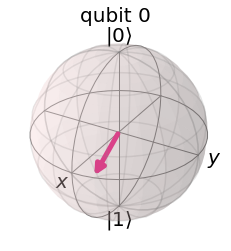

In [6]:
# Create random 1-qubit state
psi = random_statevector(2)

# Display it nicely
display(array_to_latex(psi, prefix="|\\psi\\rangle ="))
# Show it on a Bloch sphere
plot_bloch_multivector(psi)

In [7]:
# Let's create our initialization instruction to create |ψ⟩ from the state |0⟩:
init_gate = Initialize(psi)
init_gate.label = "init"

## 3.2 Using the Simulated Statevector 

We can use the Aer simulator to verify our qubit has been teleported.

In [8]:
## SETUP
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

## STEP 0
# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

# Display the circuit
qc.draw()

┌───────────────────────────────────────────┐ ░            ░      ┌───┐»
  q_0: ┤ init(-0.057107+0.25857j,0.94691-0.18233j) ├─░────────────░───■──┤ H ├»
       └───────────────────────────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘»
  q_1: ──────────────────────────────────────────────░─┤ H ├──■───░─┤ X ├─────»
                                                     ░ └───┘┌─┴─┐ ░ └───┘     »
  q_2: ──────────────────────────────────────────────░──────┤ X ├─░───────────»
                                                     ░      └───┘ ░           »
crz: 1/═══════════════════════════════════════════════════════════════════════»
                                                                              »
crx: 1/═══════════════════════════════════════════════════════════════════════»
                                                                              »
«        ░ ┌─┐                 
«  q_0: ─░─┤M├─────────────────
«        ░ └╥┘┌─┐              
«  q_1: ─░──╫─┤M├──────────────
«        ░  ║ └╥┘ ┌───┐  ┌───┐ 
«  q_2: ─░──╫──╫──┤ X ├──┤ Z ├─
«        ░  ║  ║  └─╥─┘  └─╥─┘ 
«           ║  ║    ║   ┌──╨──┐
«crz: 1/════╩══╬════╬═══╡ 0x1 ╞
«           0  ║ ┌──╨──┐└─────┘
«crx: 1/═══════╩═╡ 0x1 ╞═══════
«              0 └─────┘

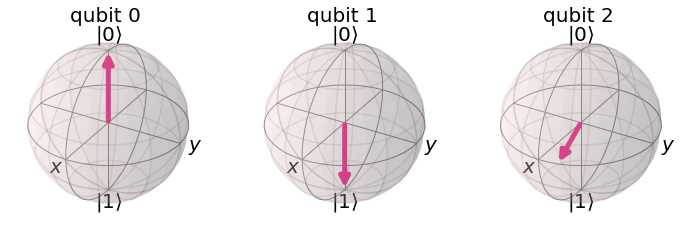

In [9]:
sim = Aer.get_backend('aer_simulator')
qc.save_statevector()
out_vector = sim.run(qc).result().get_statevector()
plot_bloch_multivector(out_vector)

You can run this cell a few times to make sure. You may notice that the qubits 0 & 1 change states, but qubit 2 is always in the state |ψ⟩.


## 3.3 Using the Simulated Counts

In [10]:
inverse_init_gate = init_gate.gates_to_uncompute()
## SETUP
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

## STEP 0
# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

## STEP 5
# reverse the initialization process
qc.append(inverse_init_gate, [2])

# Display the circuit
qc.draw()

┌───────────────────────────────────────────┐ ░            ░      ┌───┐»
  q_0: ┤ init(-0.057107+0.25857j,0.94691-0.18233j) ├─░────────────░───■──┤ H ├»
       └───────────────────────────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘»
  q_1: ──────────────────────────────────────────────░─┤ H ├──■───░─┤ X ├─────»
                                                     ░ └───┘┌─┴─┐ ░ └───┘     »
  q_2: ──────────────────────────────────────────────░──────┤ X ├─░───────────»
                                                     ░      └───┘ ░           »
crz: 1/═══════════════════════════════════════════════════════════════════════»
                                                                              »
crx: 1/═══════════════════════════════════════════════════════════════════════»
                                                                              »
«        ░ ┌─┐                                 
«  q_0: ─░─┤M├─────────────────────────────────
«        ░ └╥┘┌─┐                              
«  q_1: ─░──╫─┤M├──────────────────────────────
«        ░  ║ └╥┘ ┌───┐  ┌───┐ ┌──────────────┐
«  q_2: ─░──╫──╫──┤ X ├──┤ Z ├─┤ disentangler ├
«        ░  ║  ║  └─╥─┘  └─╥─┘ └──────────────┘
«           ║  ║    ║   ┌──╨──┐                
«crz: 1/════╩══╬════╬═══╡ 0x1 ╞════════════════
«           0  ║ ┌──╨──┐└─────┘                
«crx: 1/═══════╩═╡ 0x1 ╞═══════════════════════
«              0 └─────┘

We can see the inverse_init_gate appearing, labelled 'disentangler' on the circuit diagram. Finally, we measure the third qubit and store the result in the third classical bit:

In [11]:
# Need to add a new ClassicalRegister
# to see the result
cr_result = ClassicalRegister(1)
qc.add_register(cr_result)
qc.measure(2,2)
qc.draw()

┌───────────────────────────────────────────┐ ░            ░      ┌───┐»
  q_0: ┤ init(-0.057107+0.25857j,0.94691-0.18233j) ├─░────────────░───■──┤ H ├»
       └───────────────────────────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘»
  q_1: ──────────────────────────────────────────────░─┤ H ├──■───░─┤ X ├─────»
                                                     ░ └───┘┌─┴─┐ ░ └───┘     »
  q_2: ──────────────────────────────────────────────░──────┤ X ├─░───────────»
                                                     ░      └───┘ ░           »
crz: 1/═══════════════════════════════════════════════════════════════════════»
                                                                              »
crx: 1/═══════════════════════════════════════════════════════════════════════»
                                                                              »
 c0: 1/═══════════════════════════════════════════════════════════════════════»
                                                                              »
«        ░ ┌─┐                                    
«  q_0: ─░─┤M├────────────────────────────────────
«        ░ └╥┘┌─┐                                 
«  q_1: ─░──╫─┤M├─────────────────────────────────
«        ░  ║ └╥┘ ┌───┐  ┌───┐ ┌──────────────┐┌─┐
«  q_2: ─░──╫──╫──┤ X ├──┤ Z ├─┤ disentangler ├┤M├
«        ░  ║  ║  └─╥─┘  └─╥─┘ └──────────────┘└╥┘
«           ║  ║    ║   ┌──╨──┐                 ║ 
«crz: 1/════╩══╬════╬═══╡ 0x1 ╞═════════════════╬═
«           0  ║ ┌──╨──┐└─────┘                 ║ 
«crx: 1/═══════╩═╡ 0x1 ╞════════════════════════╬═
«              0 └─────┘                        ║ 
« c0: 1/════════════════════════════════════════╩═
«                                               0

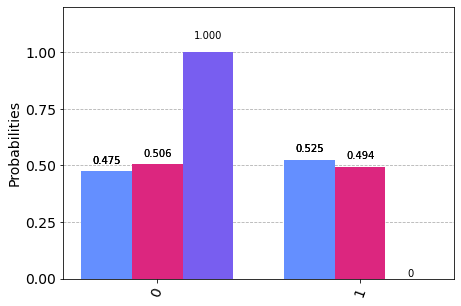

In [12]:
# run our experiment:
t_qc = transpile(qc, sim)
t_qc.save_statevector()
counts = sim.run(t_qc).result().get_counts()
qubit_counts = [marginal_counts(counts, [qubit]) for qubit in range(3)]
plot_histogram(qubit_counts)

# 5. Teleportation on a Real Quantum Computer


In [13]:
def new_bob_gates(qc, a, b, c):
    qc.cx(b, c)
    qc.cz(a, c)

In [14]:
qc = QuantumCircuit(3,1)

# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)
qc.barrier()
# Alice sends classical bits to Bob
new_bob_gates(qc, 0, 1, 2)

# We undo the initialization process
qc.append(inverse_init_gate, [2])

# See the results, we only care about the state of qubit 2
qc.measure(2,0)

# View the results:
qc.draw()

┌───────────────────────────────────────────┐ ░            ░      ┌───┐ ░ »
q_0: ┤ init(-0.057107+0.25857j,0.94691-0.18233j) ├─░────────────░───■──┤ H ├─░─»
     └───────────────────────────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ »
q_1: ──────────────────────────────────────────────░─┤ H ├──■───░─┤ X ├──────░─»
                                                   ░ └───┘┌─┴─┐ ░ └───┘      ░ »
q_2: ──────────────────────────────────────────────░──────┤ X ├─░────────────░─»
                                                   ░      └───┘ ░            ░ »
c: 1/══════════════════════════════════════════════════════════════════════════»
                                                                               »
«                                
«q_0: ──────■────────────────────
«           │                    
«q_1: ──■───┼────────────────────
«     ┌─┴─┐ │ ┌──────────────┐┌─┐
«q_2: ┤ X ├─■─┤ disentangler ├┤M├
«     └───┘   └──────────────┘└╥┘
«c: 1/═════════════════════════╩═
«                              0